In [11]:
%pip install -r requirements.txt

  Using cached Pyro-3.16.tar.gz (298 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      Traceback (most recent call last):
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", l

# Modeling

## Import data

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from pytorch_tcn import TCN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime

In [30]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/cleaned_data.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (121625, 25)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False


In [32]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0


## Preprocessing

In [33]:
# Extract time features
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter,hour,day_of_week,month
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,3,10
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,6,3,10
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,3,10
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,2,10
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,2,10


In [34]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'year_month',
       'cluster', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'hour', 'day_of_week', 'month'],
      dtype='object')

In [35]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage',
       'PRCP', 'hour', 'day_of_week', 'month']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lost {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lost 1.61% of data by removing NA


In [36]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Old:

RF

rf = RandomForestRegressor(
    n_estimators=190,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=3,      # Minimum samples required to split a node
    min_samples_leaf=3,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

Best score: 23.469028992220643

XGBoost
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
Best mse: 22.214858875924424

TCN
num_channels = [16, 32, 64, 128]  # Number of filters in each layer
kernel_size = 5
dropout = 0.3
model = HybridTCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best KNN Test MSE: 29.4558

# Random Forest

In [38]:
param_grid = {
    'n_estimators': [_ for _ in range(150, 251, 25)],
    'max_depth': [_ for _ in range(10, 21)],
    'min_samples_split': [_ for _ in range(2, 5)],
    'min_samples_leaf': [_ for _ in range(2, 5)]
}

# min_samples_split=3, min_samples_leaf=3, n_estimators=190
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                    n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print best parameters and score from grid search
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

# Get the best estimator
rf = grid.best_estimator_

/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250}
Best mse: 16.04237449579302


In [50]:
rf = RandomForestRegressor(
    n_estimators=250,         # Number of trees in the forest
    max_depth=20,           # Maximum depth of each tree
    min_samples_split=4,      # Minimum samples required to split a node
    min_samples_leaf=2,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

# Step 2: Fit the model
rf.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf.predict(X_test)

# Step 4: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16.145287846800496
Mean Absolute Error: 2.5098619588374076
R^2 Score: 0.6182386890929961


# XGBoost

In [46]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [11, 12, 13], # 12
    'learning_rate': [0.02, 0.03, 0.04], # 0.03
    'n_estimators': [700, 750, 800], # 600
    'subsample': [0.85, 0.9], # 0.9
    'colsample_bytree': [0.85, 0.9] # 0.8
}

# Initialize the XGBoost regressor
xgb_ = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# CV
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)

grid.fit(X_train, y_train)

# Display results
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
Best mse: 12.872662893439998


In [51]:
# Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 11, 'n_estimators': 800, 'subsample': 0.9}
# Best mse: 12.872662893439998
best_xgb = grid.best_estimator_

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Squared Error: {mae_xgb}")
print(f"R^2 Score: {r2_xgb}")

Mean Squared Error: 12.985049687177547
Mean Squared Error: 2.1314111844969097
R^2 Score: 0.6929636908423502


# Neural Network

In [64]:
'''
Old, from attention
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
'''

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# Temporal Convolutional Network (TCN) Model
# ----------------------------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.batch_norm1 = nn.BatchNorm1d(output_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(output_dim, output_dim, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.batch_norm2 = nn.BatchNorm1d(output_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.batch_norm1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.batch_norm2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(input_dim, output_dim, 1) if input_dim != output_dim else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size, stride=1, 
                              dilation=dilation, padding=(kernel_size-1) * dilation, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        out = self.network(x)
        out = out.mean(dim=2)  # Global average pooling over the sequence
        return self.fc(out)

# ----------------------------
# Data Preparation
# ----------------------------
scaler_x = StandardScaler()

# Fit scalers on training data and transform both train and test data
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Convert scaled data to PyTorch tensors, keeping y values unscaled
train_x = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)  # Add dummy sequence dimension
train_y = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)
test_x = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
test_y = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)

# Create DataLoader for batching
batch_size = 32  # Smaller batch size for noisy data
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=False)

# ----------------------------
# Model and Training Setup
# ----------------------------
input_size = X_train.shape[1]
output_size = 1  # Single target
num_channels = [64, 128, 256] # Filters
kernel_size = 5
dropout = 0.2

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()  # Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ----------------------------
# Training with Early Stopping
# ----------------------------
epochs = 100
patience = 10
min_delta = 1e-4
best_loss = float('inf')
stop_indicator = 0

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs), desc="Training TCN"):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    # Early stopping
    if avg_test_loss + min_delta < best_loss:
        best_loss = avg_test_loss
        stop_indicator = 0
    else:
        stop_indicator += 1
    if stop_indicator >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# ----------------------------
# Save Train and Test Losses and Plot
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.show()

Training TCN:   0%|          | 0/100 [00:00<?, ?it/s]

# Bayesian Neural Network

In [139]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# Bayesian Neural Network Model with Increased Complexity
# ----------------------------
class BayesianNN(PyroModule):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, hidden_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.75).expand([hidden_dim]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](hidden_dim, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 0.75).expand([1, hidden_dim]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 0.75).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc3(x).squeeze(-1)
        sigma = pyro.sample("sigma", dist.HalfNormal(1.0))  # More flexible noise variance
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# ----------------------------
# Prepare Data with Feature Scaling
# ----------------------------
scaler_x = StandardScaler()

# Fit scalers on training data and transform both train and test data
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Convert scaled data to PyTorch tensors, preserving original y values
train_x = torch.tensor(X_train_scaled, dtype=torch.float32)
train_y = torch.tensor(y_train.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)
test_x = torch.tensor(X_test_scaled, dtype=torch.float32)
test_y = torch.tensor(y_test.to_numpy(dtype=np.float32).reshape(-1, 1).flatten(), dtype=torch.float32)

# Create DataLoader for batching
batch_size = 16
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)

# ----------------------------
# Training Setup with Reduced Regularization and Scheduler
# ----------------------------
input_dim = train_x.shape[1]
hidden_dim = 200  # Increased hidden dimension
model = BayesianNN(input_dim, hidden_dim)

# Define the guide
def guide(x, y=None):
    for name, module in model.named_modules():
        for param_name, param in module.named_parameters(recurse=False):
            full_name = f"{name}.{param_name}" if name else param_name
            if isinstance(param, PyroSample):
                pyro.sample(full_name, dist.Normal(
                    loc=pyro.param(f"{full_name}_loc", torch.randn_like(param)),
                    scale=pyro.param(f"{full_name}_scale", torch.ones_like(param), constraint=dist.constraints.positive)
                ))
    pyro.sample("sigma", dist.Normal(
        loc=pyro.param("sigma_loc", torch.tensor(1.0)),
        scale=pyro.param("sigma_scale", torch.tensor(0.1), constraint=dist.constraints.positive)
    ))

# Define optimizer and SVI with reduced regularization (KL term)
optimizer = Adam({"lr": 1e-5, "weight_decay": 1e-5})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1, tail_adaptive_beta=0.5))  # Reduce KL weight

# ----------------------------
# Train the Model with MSE Tracking
# ----------------------------
epochs = 100
train_losses = []  # ELBO train losses
test_losses = []   # ELBO test losses
train_mse_list = []  # Train MSE
test_mse_list = []   # Test MSE

for epoch in tqdm(range(epochs), desc="Training BNN"):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        loss = svi.step(batch_x, batch_y)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping
        epoch_loss += loss

    # Calculate average train loss (ELBO)
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate train and test losses
    model.eval()
    with torch.no_grad():
        # Train MSE
        predictive_train = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=("obs",))
        train_predictions = predictive_train(train_x)
        train_pred_means = train_predictions["obs"].mean(0)
        train_mse = mean_squared_error(train_y.numpy(), train_pred_means.numpy())
        train_mse_list.append(train_mse)

        # Test MSE
        predictive_test = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=("obs",))
        test_predictions = predictive_test(test_x)
        test_pred_means = test_predictions["obs"].mean(0)
        test_loss = torch.mean((test_pred_means - test_y) ** 2).item()
        test_losses.append(test_loss)
        test_mse = mean_squared_error(test_y.numpy(), test_pred_means.numpy())
        test_mse_list.append(test_mse)

    print(
        f"Epoch {epoch + 1}/{epochs} | Train Loss (ELBO): {avg_train_loss:.4f} | "
        f"Test Loss (ELBO): {test_loss:.4f} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}"
    )

# ----------------------------
# Plot Train vs Test Loss and MSE
# ----------------------------
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss (ELBO)")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss (ELBO)")
plt.plot(range(1, epochs + 1), train_mse_list, label="Train MSE")
plt.plot(range(1, epochs + 1), test_mse_list, label="Test MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss and MSE Over Epochs")
plt.legend()
plt.grid()
plt.show()

Training BNN:   1%|          | 1/100 [01:40<2:45:17, 100.18s/it]

Epoch 1/100 | Train Loss (ELBO): 51059.0900 | Test Loss (ELBO): 87.2311 | Train MSE: 88.2798 | Test MSE: 87.2311


Training BNN:   2%|▏         | 2/100 [03:21<2:44:53, 100.95s/it]

Epoch 2/100 | Train Loss (ELBO): 51043.0590 | Test Loss (ELBO): 121.0359 | Train MSE: 153.4687 | Test MSE: 121.0359


Training BNN:   3%|▎         | 3/100 [05:02<2:43:07, 100.90s/it]

Epoch 3/100 | Train Loss (ELBO): 51056.9143 | Test Loss (ELBO): 77.6630 | Train MSE: 275.8461 | Test MSE: 77.6630


Training BNN:   3%|▎         | 3/100 [06:08<3:18:19, 122.67s/it]


KeyboardInterrupt: 

In [53]:
mse_bnn = mean_squared_error(y_test, pred_means_original)
print(f"BNN Test MSE: {mse_bnn:.4f}")

BNN Test MSE: 47.7514


# KNN

Best KNN Test MSE: 25.0324
Best KNN Test MAE: 3.2441
Best KNN r^2 score: 0.4081


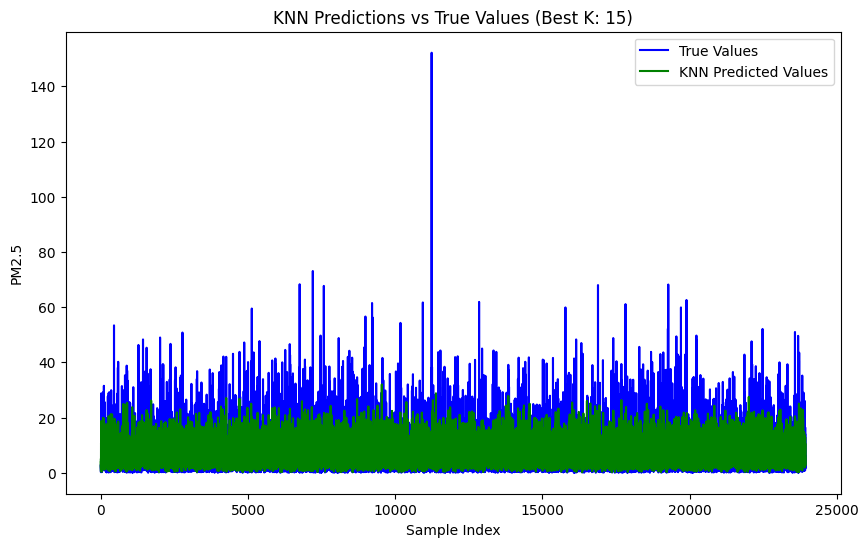

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(8, 20),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Uniform weights or distance-based
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Predict on the test set using the best KNN model
y_pred_knn = best_knn.predict(X_test_scaled)

# Calculate the MSE for the best KNN model
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"Best KNN Test MSE: {mse_knn:.4f}")
print(f"Best KNN Test MAE: {mae_knn:.4f}")
print(f"Best KNN r^2 score: {r2_knn:.4f}")

# Plot the true values vs the KNN predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.to_numpy(), label="True Values", color="blue")
plt.plot(y_pred_knn, label="KNN Predicted Values", color="green")
plt.legend()
plt.title(f"KNN Predictions vs True Values (Best K: {best_params['n_neighbors']})")
plt.xlabel("Sample Index")
plt.ylabel("PM2.5")
plt.show()

# Interpretability

In [9]:
import matplotlib.pyplot as plt

plt.ioff()

## Residual Plot

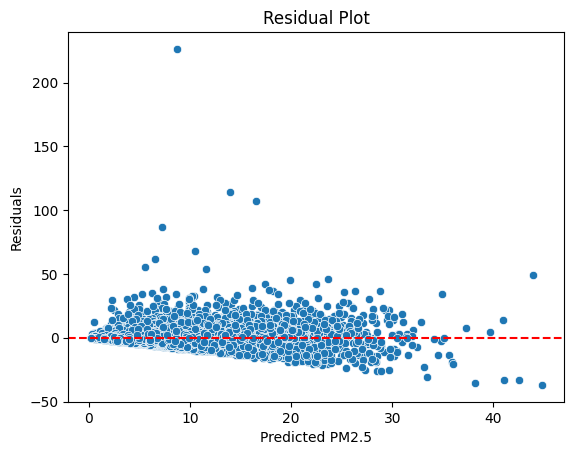

In [15]:
import seaborn as sns

y_pred = rf_regressor.predict(X_test)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## PDP

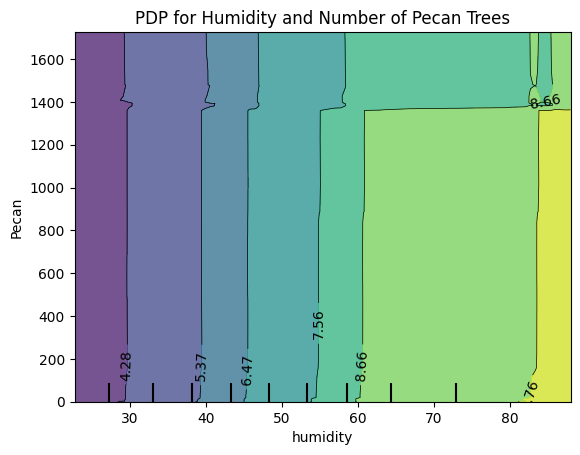

In [13]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# features_PDP = ['humidity']
features_PDP = [('humidity', 'Pecan')]

PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='average')
plt.title('PDP for Humidity and Number of Pecan Trees')
plt.show()

In [32]:
for f in features:
    PartialDependenceDisplay.from_estimator(rf_regressor, X, [f], kind='average')
    name = f.lower().replace(' ', '_')
    title_case = f.replace('_', ' ').replace('PRCP', 'Precipitation').title()
    plt.title(f'PDP for {title_case}')
    plt.xlabel(title_case)
    plt.savefig(f'./plots/pdp_{name}', dpi=300, bbox_inches='tight')
    plt.close()

## ICE

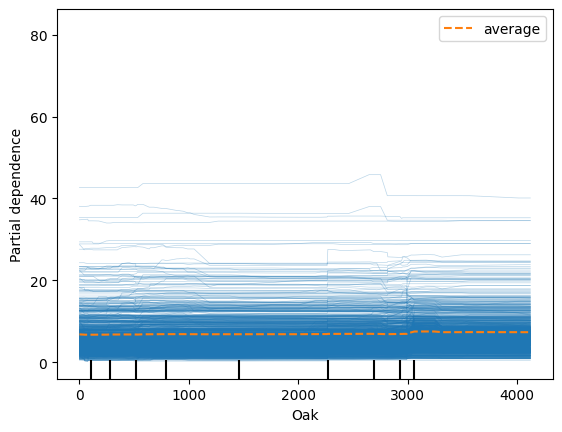

In [13]:
# Takes a long time to run
PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='both')
plt.title('ICE plot')
plt.show()

## ALE

In [ ]:
from PyALE import ale

ale_eff = ale(X=X, model=rf_regressor, feature=features_PDP, grid_size=50, include_CI=False)
plt.title('ALE plot')
plt.show()

## SHAP

In [21]:
import shap

explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer(X_train.sample(n=5000, random_state=42))

In [28]:
plt.figure()
shap.plots.waterfall(shap_values[2], show=False)
plt.title('Shapley Value Waterfall Plot')
plt.savefig('./plots/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title('Shapley Value Beeswarm Plot')
plt.savefig('./plots/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()